# ANCOVA analysis

In [1]:
# include a PCA colored by groups as well as covariance factors 

Import data.

In [2]:
import pandas as pd
import acore.differential_regulation as ad
from pathlib import Path
import numpy as np

folder_out = Path("data")

In [3]:
CLINIC: str = 'https://raw.githubusercontent.com/RasmussenLab/njab/HEAD/docs/tutorial/data/alzheimer/clinic_ml.csv'  # clincial data
OMICS: str = 'https://raw.githubusercontent.com/RasmussenLab/njab/HEAD/docs/tutorial/data/alzheimer/proteome.csv'  # omics data

In [4]:
clinic = pd.read_csv(CLINIC, index_col=0).convert_dtypes()
omics = pd.read_csv(OMICS, index_col=0)

In [5]:
clinic

,Kiel,Magdeburg,Sweden,male,age,AD
Sample ID,,,,,,
Sample_000,0,0,1,0,71,0
Sample_001,0,0,1,1,77,1
Sample_002,0,0,1,1,75,1
Sample_003,0,0,1,0,72,1
Sample_004,0,0,1,0,63,1
...,...,...,...,...,...,...
Sample_205,0,0,0,0,69,1
Sample_206,0,0,0,1,73,0
Sample_207,0,0,0,0,71,0


In [6]:
omics

,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3B9;E9PJL7;E9PNH7;E9PR44;E9PRA8;P02511,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,61673.894531,118287.296875,NaN,48660.886719,91474.398438,161523.437500,1.243916e+06,111328.523438,196418.406250,129966.304688,...,66103.218750,37065.339844,NaN,33928.589844,117492.835938,9.537048e+05,NaN,7.744526e+05,7319.068848,7157.334473
Sample_001,62683.871094,120084.656250,NaN,46952.789062,85696.210938,14219.551758,1.006628e+06,452086.125000,144818.046875,NaN,...,47247.085938,48831.750000,NaN,29184.250000,99154.421875,1.290353e+06,48161.156250,6.850029e+05,16046.540039,5566.107422
Sample_002,70801.492188,23540.431641,NaN,62662.648438,87425.625000,295910.656250,6.238746e+05,116678.054688,52162.660156,132150.765625,...,38397.007812,27131.826172,13840.273438,35567.585938,177753.437500,7.934898e+05,54547.285156,1.429741e+06,6367.055176,5811.354004
Sample_003,70579.843750,133966.578125,NaN,57126.406250,129144.039062,63886.269531,8.102269e+05,236600.234375,481605.812500,18580.904297,...,46175.460938,24667.812500,26278.039062,36111.652344,167765.281250,7.057533e+05,NaN,1.217900e+06,6326.340820,5574.454102
Sample_004,49777.761719,41204.300781,NaN,42501.414062,104929.156250,45487.113281,1.432224e+06,420529.000000,138671.140625,18056.232422,...,27682.402344,34978.042969,16933.244141,39127.046875,138061.406250,7.848058e+05,41140.679688,9.563047e+05,9055.215820,4819.975098
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,52580.968750,121142.914062,17094.783203,30787.574219,91553.039062,NaN,2.136448e+05,134705.750000,NaN,87260.187500,...,38577.703125,52639.847656,19290.646484,43690.750000,192023.203125,2.483209e+05,82961.828125,9.972978e+05,7800.821777,3571.951904
Sample_206,56974.929688,192433.843750,39391.933594,49655.160156,62771.390625,NaN,2.917747e+05,291227.625000,92853.867188,118952.796875,...,43910.460938,70548.421875,NaN,41630.660156,138975.265625,4.282637e+05,19466.386719,7.076132e+05,NaN,NaN
Sample_207,54708.843750,120377.539062,NaN,45354.527344,122102.546875,NaN,4.074621e+05,253284.093750,81851.984375,86517.843750,...,57367.875000,70132.867188,21659.679688,53800.195312,98345.039062,4.332331e+05,72127.773438,7.941901e+05,12739.789062,2310.060547


### Filtering data

If data is already filtered and/or imputed, skip this step. 

In [7]:
# Filtering parameters
freq_cutoff = 0.7


In [8]:
M_before = omics.shape[1]
omics = omics.dropna(thresh=int(len(omics) * freq_cutoff), axis=1)
M_after = omics.shape[1]
msg = (
    f"Removed {M_before-M_after} features with more than {freq_cutoff*100}% missing values." # if theres 100 feat with >30% missing, how can there be 400 feat with >70% 
    f"\nRemaining features: {M_after} (of {M_before})")
print(msg)
# keep a map of all proteins in protein group, but only display first protein
# proteins are unique to protein groups
pg_map = {k: k.split(";")[0] for k in omics.columns}
omics = omics.rename(columns=pg_map)
# log2 transform raw intensity data:
omics = np.log2(omics + 1)
omics

Removed 432 features with more than 70.0% missing values.
Remaining features: 1110 (of 1542)


,A0A024QZX5,A0A024R0T9,A0A024R3W6,A0A024R644,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y5Y7,Q9Y617,Q9Y646,Q9Y653,Q9Y696,Q9Y6N6,Q9Y6N7,Q9Y6R7,Q9Y6X5,Q9Y6Y8
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912396,16.851948,15.570505,16.481096,20.246459,16.764477,17.583578,16.987789,20.054164,NaN,...,18.839571,16.858981,19.321964,16.012455,15.177822,15.050256,16.842226,19.863185,NaN,19.562819
Sample_001,15.935830,16.873704,15.518954,16.386961,19.941101,18.786241,17.143892,NaN,19.067333,16.188013,...,19.194954,16.799285,19.190296,15.527968,15.575561,14.832952,16.597404,20.299335,15.555612,19.385753
Sample_002,16.111513,14.522914,15.935341,16.415785,19.250899,16.832186,15.670757,17.011836,18.569061,NaN,...,19.088201,16.287838,19.701946,15.228744,14.727752,15.118316,17.439526,19.597854,15.735246,20.447324
Sample_003,16.106989,17.031524,15.801895,16.978633,19.627968,17.852098,18.877496,14.181611,18.985068,13.438257,...,18.714969,17.074910,19.760136,15.494870,14.590401,15.140217,17.356093,19.428807,NaN,20.215965
Sample_004,15.603243,15.330542,15.375257,16.679070,20.449827,18.681849,17.081318,14.140289,19.685645,14.494901,...,18.668248,16.736289,19.623692,14.756734,15.094203,15.255915,17.074961,19.581978,15.328313,19.867112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682281,16.886362,14.910107,16.482336,17.704861,17.039463,NaN,16.413052,19.102116,16.064249,...,18.726395,15.808337,19.893882,15.235517,15.683895,15.415073,17.550929,17.921852,16.340177,19.927666
Sample_206,15.798065,17.554011,15.599685,15.937843,18.154500,18.151793,16.502690,16.860042,18.537962,15.287740,...,18.460111,15.035333,20.014575,15.422310,16.106347,15.345393,17.084479,18.708143,14.248772,19.432603
Sample_207,15.739513,16.877219,15.468991,16.897746,18.636310,17.950403,16.320747,16.400727,18.848971,17.580450,...,19.501515,16.283074,20.306141,15.807981,16.097824,15.715351,16.585579,18.724787,16.138287,19.599127


Consider replacing with the filter from the acore package!

### Preparing metadata

In [9]:
clinic['age'].info()

<class 'pandas.core.series.Series'>
Index: 210 entries, Sample_000 to Sample_209
Series name: age
Non-Null Count  Dtype
--------------  -----
197 non-null    Int64
dtypes: Int64(1)
memory usage: 3.5+ KB


In [10]:
clinic_omics = omics.join(clinic)
clinic_omics

,A0A024QZX5,A0A024R0T9,A0A024R3W6,A0A024R644,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y6N7,Q9Y6R7,Q9Y6X5,Q9Y6Y8,Kiel,Magdeburg,Sweden,male,age,AD
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912396,16.851948,15.570505,16.481096,20.246459,16.764477,17.583578,16.987789,20.054164,NaN,...,16.842226,19.863185,NaN,19.562819,0,0,1,0,71,0
Sample_001,15.935830,16.873704,15.518954,16.386961,19.941101,18.786241,17.143892,NaN,19.067333,16.188013,...,16.597404,20.299335,15.555612,19.385753,0,0,1,1,77,1
Sample_002,16.111513,14.522914,15.935341,16.415785,19.250899,16.832186,15.670757,17.011836,18.569061,NaN,...,17.439526,19.597854,15.735246,20.447324,0,0,1,1,75,1
Sample_003,16.106989,17.031524,15.801895,16.978633,19.627968,17.852098,18.877496,14.181611,18.985068,13.438257,...,17.356093,19.428807,NaN,20.215965,0,0,1,0,72,1
Sample_004,15.603243,15.330542,15.375257,16.679070,20.449827,18.681849,17.081318,14.140289,19.685645,14.494901,...,17.074961,19.581978,15.328313,19.867112,0,0,1,0,63,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682281,16.886362,14.910107,16.482336,17.704861,17.039463,NaN,16.413052,19.102116,16.064249,...,17.550929,17.921852,16.340177,19.927666,0,0,0,0,69,1
Sample_206,15.798065,17.554011,15.599685,15.937843,18.154500,18.151793,16.502690,16.860042,18.537962,15.287740,...,17.084479,18.708143,14.248772,19.432603,0,0,0,1,73,0
Sample_207,15.739513,16.877219,15.468991,16.897746,18.636310,17.950403,16.320747,16.400727,18.848971,17.580450,...,16.585579,18.724787,16.138287,19.599127,0,0,0,0,71,0


In [11]:
omics_group = clinic_omics.drop(columns = ['Kiel','Magdeburg','Sweden','male','age'])

In [12]:
omics_group

,A0A024QZX5,A0A024R0T9,A0A024R3W6,A0A024R644,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y617,Q9Y646,Q9Y653,Q9Y696,Q9Y6N6,Q9Y6N7,Q9Y6R7,Q9Y6X5,Q9Y6Y8,AD
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912396,16.851948,15.570505,16.481096,20.246459,16.764477,17.583578,16.987789,20.054164,NaN,...,16.858981,19.321964,16.012455,15.177822,15.050256,16.842226,19.863185,NaN,19.562819,0
Sample_001,15.935830,16.873704,15.518954,16.386961,19.941101,18.786241,17.143892,NaN,19.067333,16.188013,...,16.799285,19.190296,15.527968,15.575561,14.832952,16.597404,20.299335,15.555612,19.385753,1
Sample_002,16.111513,14.522914,15.935341,16.415785,19.250899,16.832186,15.670757,17.011836,18.569061,NaN,...,16.287838,19.701946,15.228744,14.727752,15.118316,17.439526,19.597854,15.735246,20.447324,1
Sample_003,16.106989,17.031524,15.801895,16.978633,19.627968,17.852098,18.877496,14.181611,18.985068,13.438257,...,17.074910,19.760136,15.494870,14.590401,15.140217,17.356093,19.428807,NaN,20.215965,1
Sample_004,15.603243,15.330542,15.375257,16.679070,20.449827,18.681849,17.081318,14.140289,19.685645,14.494901,...,16.736289,19.623692,14.756734,15.094203,15.255915,17.074961,19.581978,15.328313,19.867112,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682281,16.886362,14.910107,16.482336,17.704861,17.039463,NaN,16.413052,19.102116,16.064249,...,15.808337,19.893882,15.235517,15.683895,15.415073,17.550929,17.921852,16.340177,19.927666,1
Sample_206,15.798065,17.554011,15.599685,15.937843,18.154500,18.151793,16.502690,16.860042,18.537962,15.287740,...,15.035333,20.014575,15.422310,16.106347,15.345393,17.084479,18.708143,14.248772,19.432603,0
Sample_207,15.739513,16.877219,15.468991,16.897746,18.636310,17.950403,16.320747,16.400727,18.848971,17.580450,...,16.283074,20.306141,15.807981,16.097824,15.715351,16.585579,18.724787,16.138287,19.599127,0


### Checking missing data

In [13]:
data_completeness = omics_group.groupby("AD").count().divide(clinic['AD'].value_counts(), axis=0)
data_completeness

,A0A024QZX5,A0A024R0T9,A0A024R3W6,A0A024R644,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y5Y7,Q9Y617,Q9Y646,Q9Y653,Q9Y696,Q9Y6N6,Q9Y6N7,Q9Y6R7,Q9Y6X5,Q9Y6Y8
AD,,,,,,,,,,,,,,,,,,,,,
0,0.934426,0.991803,0.844262,0.983607,0.942623,0.983607,0.934426,0.860656,1.0,0.827869,...,1.0,0.983607,1.0,0.852459,0.860656,0.97541,0.92623,1.0,0.868852,1.0
1,0.943182,0.988636,0.931818,1.0,0.977273,0.988636,0.886364,0.931818,1.0,0.727273,...,0.988636,1.0,1.0,0.965909,0.909091,0.965909,0.965909,1.0,0.909091,1.0


<Axes: >

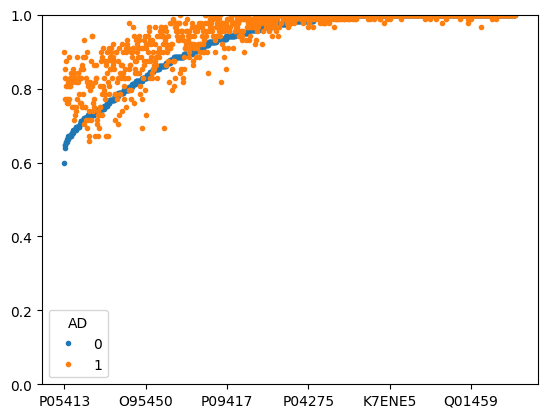

In [14]:
data_completeness.T.sort_values(0).plot(style='.',ylim=(0,1))

### Running ANCOVA analysis

In [15]:
clinic_omics

,A0A024QZX5,A0A024R0T9,A0A024R3W6,A0A024R644,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y6N7,Q9Y6R7,Q9Y6X5,Q9Y6Y8,Kiel,Magdeburg,Sweden,male,age,AD
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912396,16.851948,15.570505,16.481096,20.246459,16.764477,17.583578,16.987789,20.054164,NaN,...,16.842226,19.863185,NaN,19.562819,0,0,1,0,71,0
Sample_001,15.935830,16.873704,15.518954,16.386961,19.941101,18.786241,17.143892,NaN,19.067333,16.188013,...,16.597404,20.299335,15.555612,19.385753,0,0,1,1,77,1
Sample_002,16.111513,14.522914,15.935341,16.415785,19.250899,16.832186,15.670757,17.011836,18.569061,NaN,...,17.439526,19.597854,15.735246,20.447324,0,0,1,1,75,1
Sample_003,16.106989,17.031524,15.801895,16.978633,19.627968,17.852098,18.877496,14.181611,18.985068,13.438257,...,17.356093,19.428807,NaN,20.215965,0,0,1,0,72,1
Sample_004,15.603243,15.330542,15.375257,16.679070,20.449827,18.681849,17.081318,14.140289,19.685645,14.494901,...,17.074961,19.581978,15.328313,19.867112,0,0,1,0,63,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682281,16.886362,14.910107,16.482336,17.704861,17.039463,NaN,16.413052,19.102116,16.064249,...,17.550929,17.921852,16.340177,19.927666,0,0,0,0,69,1
Sample_206,15.798065,17.554011,15.599685,15.937843,18.154500,18.151793,16.502690,16.860042,18.537962,15.287740,...,17.084479,18.708143,14.248772,19.432603,0,0,0,1,73,0
Sample_207,15.739513,16.877219,15.468991,16.897746,18.636310,17.950403,16.320747,16.400727,18.848971,17.580450,...,16.585579,18.724787,16.138287,19.599127,0,0,0,0,71,0


In [16]:
clinic_omics.index.to_series().info() 

<class 'pandas.core.series.Series'>
Index: 210 entries, Sample_000 to Sample_209
Series name: Sample ID
Non-Null Count  Dtype 
--------------  ----- 
210 non-null    object
dtypes: object(1)
memory usage: 3.3+ KB


In [17]:
clinic_omics.dtypes.value_counts()

float64    1110
Int64         6
Name: count, dtype: int64

In [18]:
col='A0A024QZX5'
group="AD"
covariates=['male',]
clinic_omics[[group, col] + covariates]

,AD,A0A024QZX5,male
Sample ID,,,
Sample_000,0,15.912396,0
Sample_001,1,15.935830,1
Sample_002,1,16.111513,1
Sample_003,1,16.106989,0
Sample_004,1,15.603243,0
...,...,...,...
Sample_205,1,15.682281,0
Sample_206,0,15.798065,1
Sample_207,0,15.739513,0


In [19]:
ad.calculate_ancova(clinic_omics.astype('float'), column='A0A024QZX5', group="AD", covariates=['male',])

('A0A024QZX5', 1.0, 1.0, 7.736456173698742, 0.00594560282196705)

In [20]:
clinic_omics

,A0A024QZX5,A0A024R0T9,A0A024R3W6,A0A024R644,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y6N7,Q9Y6R7,Q9Y6X5,Q9Y6Y8,Kiel,Magdeburg,Sweden,male,age,AD
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912396,16.851948,15.570505,16.481096,20.246459,16.764477,17.583578,16.987789,20.054164,NaN,...,16.842226,19.863185,NaN,19.562819,0,0,1,0,71,0
Sample_001,15.935830,16.873704,15.518954,16.386961,19.941101,18.786241,17.143892,NaN,19.067333,16.188013,...,16.597404,20.299335,15.555612,19.385753,0,0,1,1,77,1
Sample_002,16.111513,14.522914,15.935341,16.415785,19.250899,16.832186,15.670757,17.011836,18.569061,NaN,...,17.439526,19.597854,15.735246,20.447324,0,0,1,1,75,1
Sample_003,16.106989,17.031524,15.801895,16.978633,19.627968,17.852098,18.877496,14.181611,18.985068,13.438257,...,17.356093,19.428807,NaN,20.215965,0,0,1,0,72,1
Sample_004,15.603243,15.330542,15.375257,16.679070,20.449827,18.681849,17.081318,14.140289,19.685645,14.494901,...,17.074961,19.581978,15.328313,19.867112,0,0,1,0,63,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682281,16.886362,14.910107,16.482336,17.704861,17.039463,NaN,16.413052,19.102116,16.064249,...,17.550929,17.921852,16.340177,19.927666,0,0,0,0,69,1
Sample_206,15.798065,17.554011,15.599685,15.937843,18.154500,18.151793,16.502690,16.860042,18.537962,15.287740,...,17.084479,18.708143,14.248772,19.432603,0,0,0,1,73,0
Sample_207,15.739513,16.877219,15.468991,16.897746,18.636310,17.950403,16.320747,16.400727,18.848971,17.580450,...,16.585579,18.724787,16.138287,19.599127,0,0,0,0,71,0


In [23]:
clinic_omics = clinic_omics.astype(float) # this is no needed for run_ancova (the regex where groups are joined)
ad.calculate_ancova(clinic_omics, column='A0A024QZX5', group="AD", covariates=['male',])

('A0A024QZX5', 1.0, 1.0, 7.736456173698742, 0.00594560282196705)

In [25]:

ancova = ad.run_ancova(
                        clinic_omics.astype({'AD':str}),
                        # subject='Sample ID', # not used
                        drop_cols=['Kiel','Magdeburg','Sweden','age',
                                   ],
                        group='AD', # needs to be a string 
                        covariates=['male',]) # need to be floats?

In [25]:
anova = ad.run_anova(clinic_omics.reset_index(),
                        subject='Sample ID',
                        drop_cols=['Kiel','Magdeburg','Sweden','age','male'],
                        group='AD')

### Running ANOVA analysis (optional)

### Comparing ANOVA and ANCOVA results